In [23]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Database, binplot, calculate, equilibrium
from pycalphad.plot.utils import phase_legend
import pycalphad.variables as v
import pandas as pd
plt.rcParams.update({'font.size': 18}) # defaults to 10.0

# Analyze the TDB file

load the database file

In [3]:
db = Database('CrFe_Jacob.tdb')

Get a list of phases and plot the phase diagram of the FeCr system.

In [4]:
phases = list(db.phases.keys())
phases

['BCC_A2', 'FCC_A1', 'LIQUID', 'SIGMA']

<AxesSubplot:title={'center':'Cr-Fe'}, xlabel='X(Cr)', ylabel='Temperature (K)'>

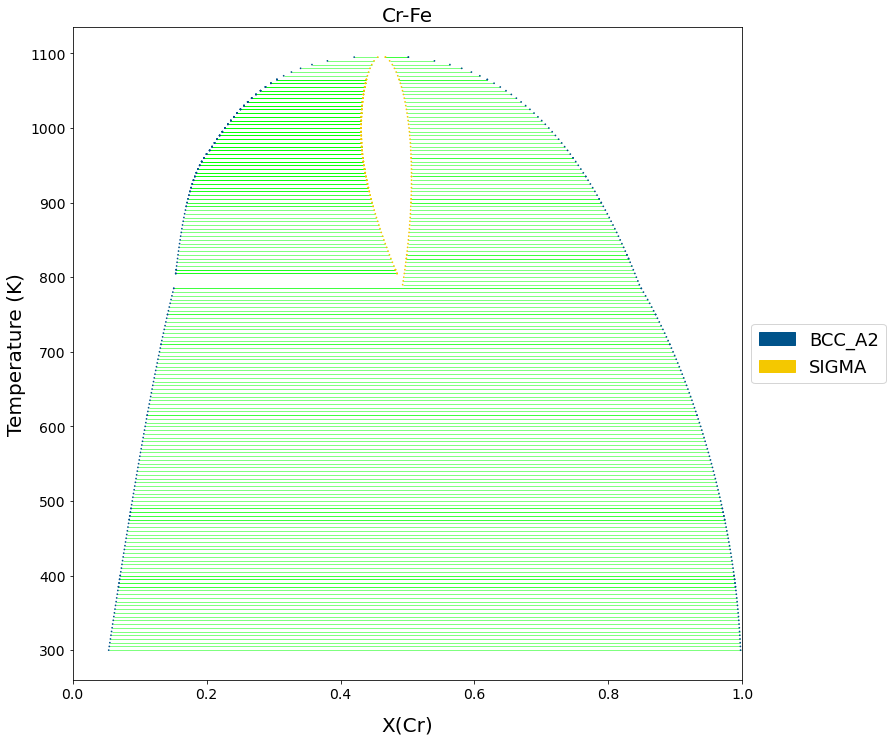

In [22]:
fig = plt.figure(figsize=(15,12))
ax=fig.gca()
binplot(db, ['Cr', 'Fe', 'VA'] , phases, 
        {v.X('Cr'):(0,1,0.005), v.T: (300, 1100, 5), v.P:101325}, plot_kwargs={'ax': ax})

we can compute the free energies at 1000K using pycalphad

In [6]:
eq_bcc = equilibrium(db, ['Cr', 'Fe', 'VA'], ['BCC_A2'], {v.X('CR'): (0,1, 0.01), v.T: 1000, v.P:101325 })
eq_sigma = equilibrium(db, ['Cr', 'Fe', 'VA'], ['SIGMA'], {v.X('CR'): (0,1, 0.01), v.T: 1000, v.P:101325 })

Those will be plotted below as a reference solution to compare to the MOOSE output.

# Solving for sublattice concentrations

Run 

```
../../phase_field-opt -i CrFe_sigma.i
```

To perform a solve for only the sigma phase sublattice concentrations.

load the solution

In [8]:
F = pd.read_csv('CrFe_sigma_out_var_0001.csv')

And plot free energies (both from pycalphad and from MOOSE)

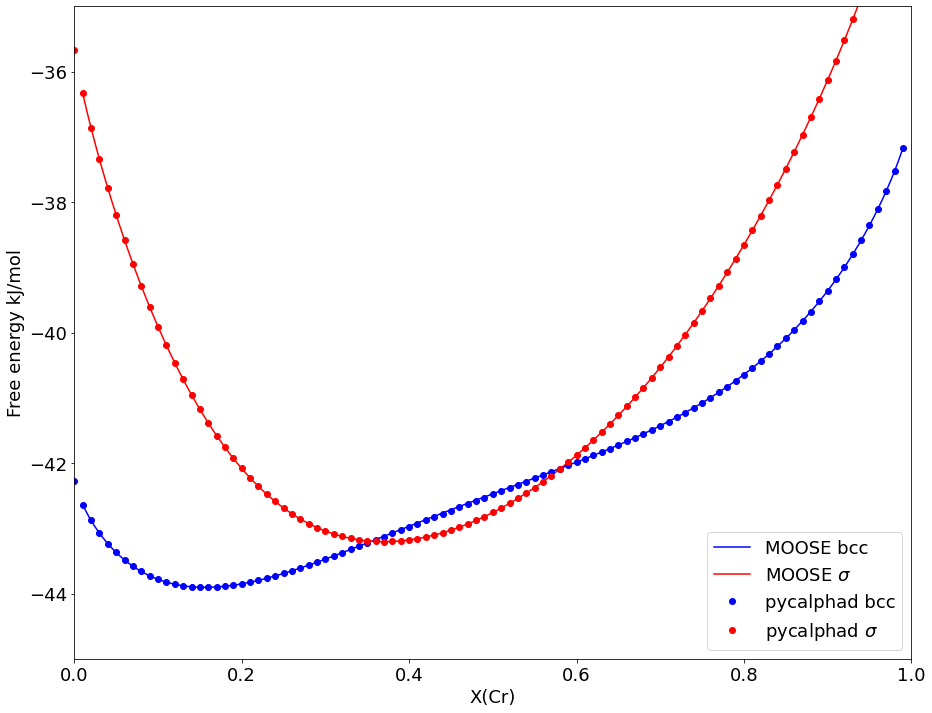

In [12]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca()

# Plot the MOOSE free energies ...
ax.plot(F['cCr'], F['Fb']/1000, 'b-', label="MOOSE bcc")
ax.plot(F['cCr'], F['Fs']/1000, 'r-', label="MOOSE $\sigma$")

# ... and the pycalphad free energies
ax.plot(eq_bcc['X_CR'].values,  eq_bcc['GM'].values[0][0][0]/1000, 'bo', label="pycalphad bcc")
ax.plot(eq_sigma['X_CR'].values, eq_sigma['GM'].values[0][0][0]/1000, 'ro', label="pycalphad $\sigma$")

ax.set_xlabel('X(Cr)')
ax.set_ylabel('Free energy kJ/mol')
ax.legend(loc='lower right')
ax.set_xlim((0, 1))
ax.set_ylim((-45,-35))
plt.show()

The free energies evaluated and solved for by MOOSE, exactly match the pycalphad free energies.

Now let's plot the sublattice concentrations as a function of the total chromium concentration.

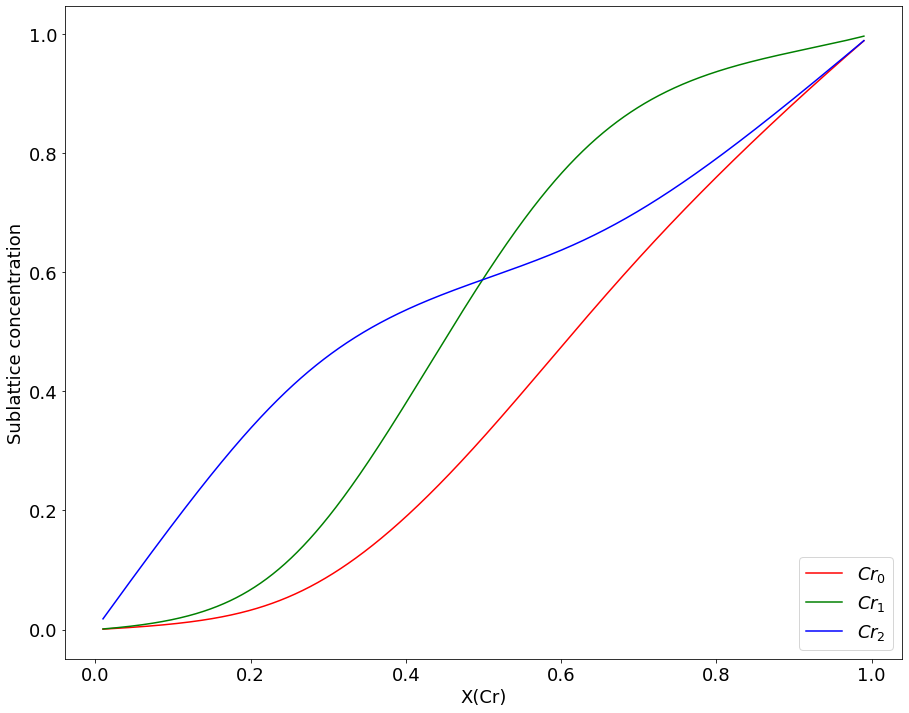

In [10]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca()
ax.plot(F['cCr'], F['SIGMA_0CR'], 'r-', label="$Cr_0$")
ax.plot(F['cCr'], F['SIGMA_1CR'], 'g-', label="$Cr_1$")
ax.plot(F['cCr'], F['SIGMA_2CR'], 'b-', label="$Cr_2$")
ax.set_xlabel('X(Cr)')
ax.set_ylabel('Sublattice concentration')
ax.legend(loc='lower right')
plt.show()

# Full solve

We will use the output `CrFe_sigma_out_var_0001.csv` from the previous simulation, where we only solved for the sublattice concentrations to inform the initial condition of the next step, a full solve. If we are simultaneously solving for mass transport, phase order parameters, and sublattice concentrations, it is very important to have a good inituial guess for the sublattice concentrations. With the previous sublattice only solve we actually have tabulated data that gets us all sublattice concentrations as a function of the chromium concentration `cCr` (see previous plot).

We will load the output CSV file using the `PiecewiseLinear` function object, and use `CoupledValueFunctionIC` set the initial conditions for the three sublattice concentrations.

Run `CrFe.i` now and let's plot some of the outputs obtained.

In [11]:
c = pd.read_csv('CrFe_out.csv')

First we look at the minimum and maximum concentrations as a function of time

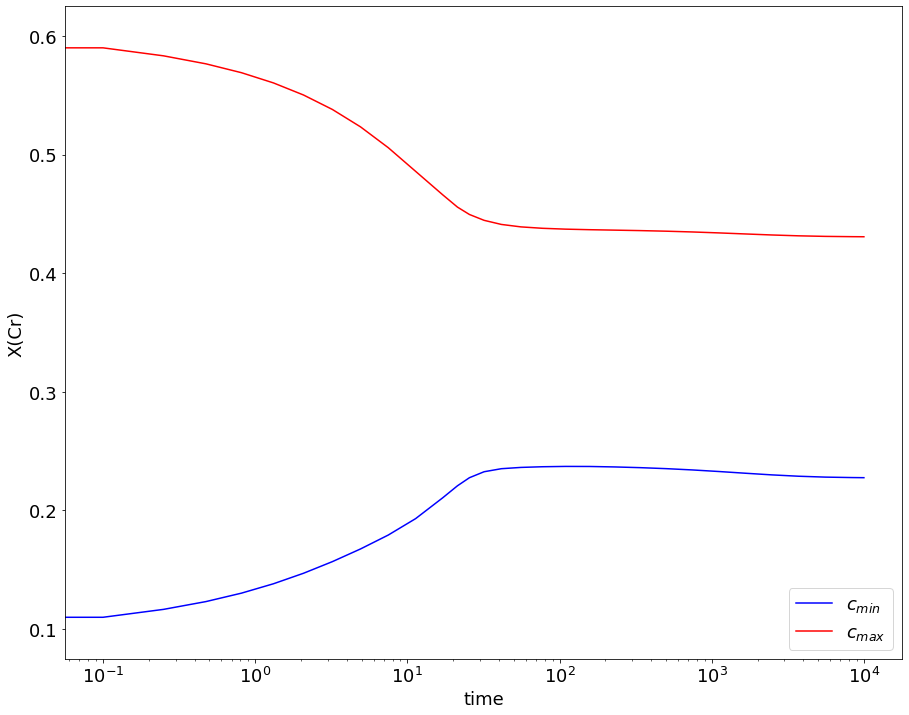

In [13]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca()
ax.plot(c['time'], c['cmin'], 'b-', label="$c_{min}$")
ax.plot(c['time'], c['cmax'], 'r-', label="$c_{max}$")
ax.set_xlabel('time')
ax.set_ylabel('X(Cr)')
ax.set_xscale('log')
ax.legend(loc='lower right')
plt.show()

Now let's plot the minimum and maximum concentrations at the end of the simulation overlaid on the phase diagram. We see that the simulation volume has cleanly separated into a _bcc_ and a $\sigma$ phase.

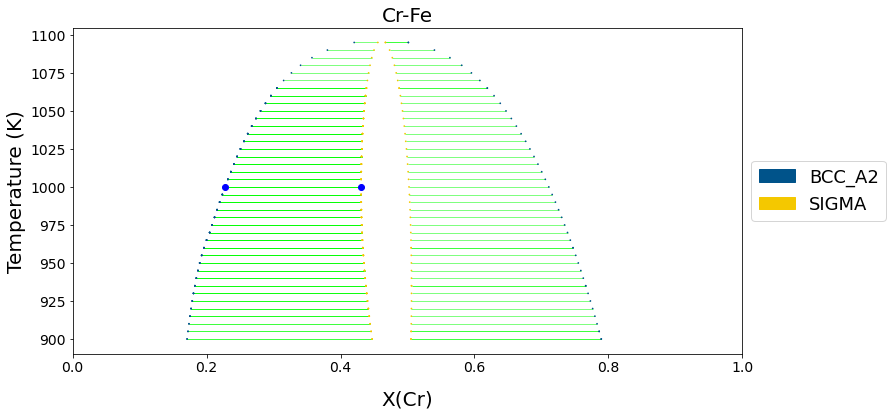

In [18]:
fig = plt.figure(figsize=(15,6))
ax=fig.gca()
binplot(db, ['Cr', 'Fe', 'VA'] , phases, 
        {v.X('Cr'):(0,1,0.005), v.T: (900, 1100, 5), v.P:101325}, plot_kwargs={'ax': ax})

# Plot the two phase concentrations at the end of the suimulation
ax.plot(list(c['cmin'])[-1], 1000, "ob")
ax.plot(list(c['cmax'])[-1], 1000, "ob")

Plotting the total free energy of the system shows a monotonous decrease.

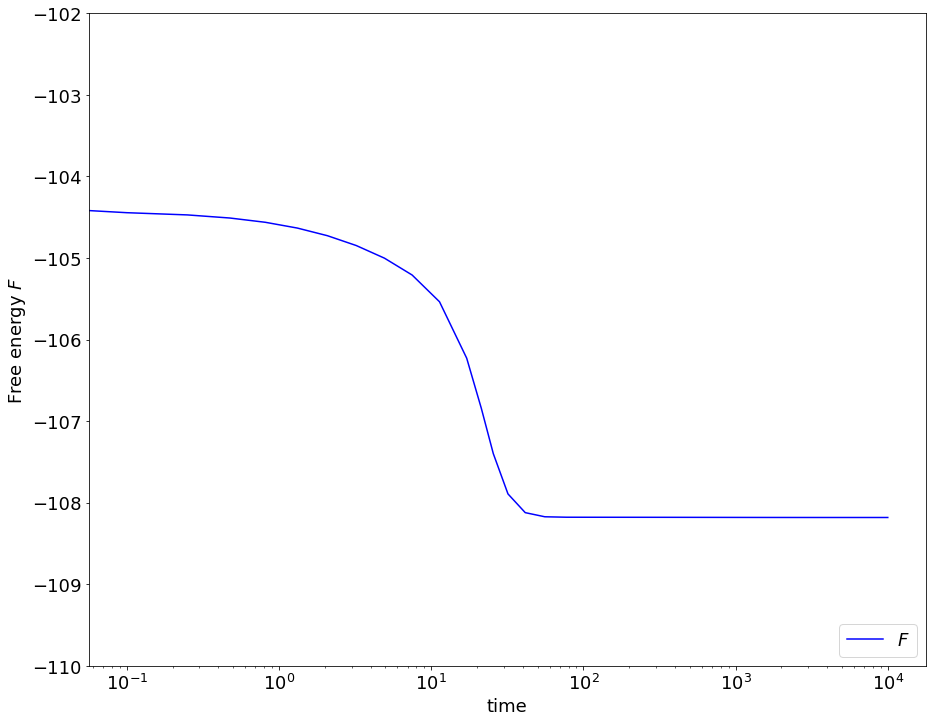

In [21]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca()
ax.plot(c['time'], c['F'], 'b-', label="$F$")
ax.set_xlabel('time')
ax.set_ylabel('Free energy $F$')
ax.set_xscale('log')
ax.set_ylim((-110,-102))
ax.legend(loc='lower right')
plt.show()

Plotting all traces of `eta1` (red), the _bcc_ phase order parameter, and teh total chromium concentration `cCr` (blue).

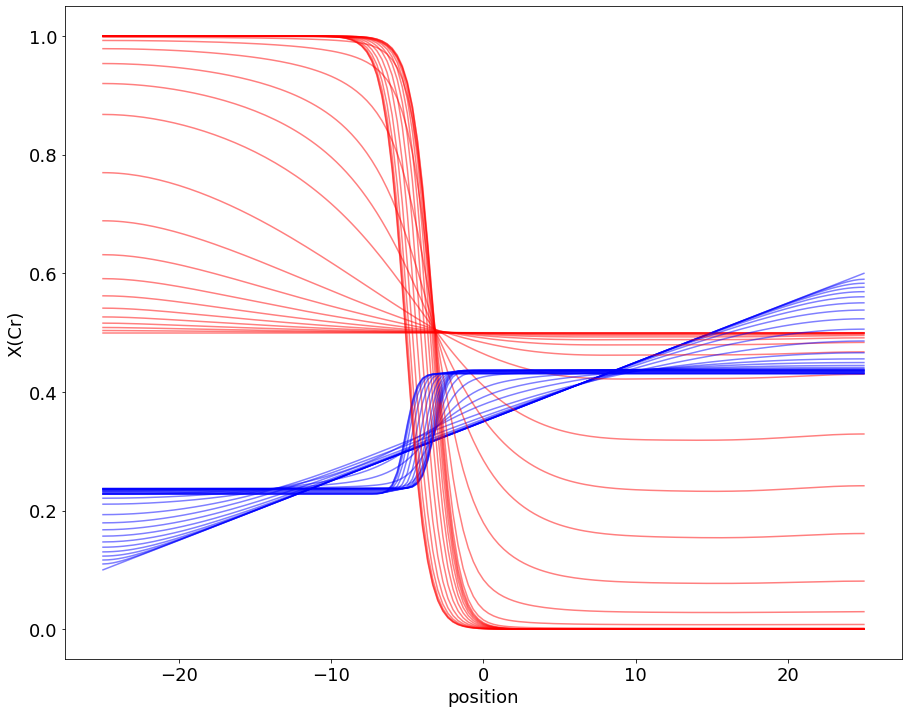

In [32]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca()

for i in range(len(c['time'])):
    s = pd.read_csv('CrFe_out_var_%04d.csv' % i)
    ax.plot(s['x'], s['cCr'], 'b-', alpha = 0.5)
    ax.plot(s['x'], s['eta1'], 'r-', alpha = 0.5)
    
ax.set_xlabel('position')
ax.set_ylabel('X(Cr)')
#ax.legend(loc='lower right')
plt.show()